# Resonance 1 fr and 1/Qi vs T

In [ ]:
# Example usage
from iminuit.cost import LeastSquares
from IRdetection.src.analysis.FitAPI import Fitter, Model
import numpy as np
import numpy as np
import sys
sys.path.append('../Graphics')
from Graphs import fitPlotter
import matplotlib.pyplot as plt
import models as md

def S21_model(f: np.ndarray, f0: float, phi: float, Qt: float, Qc: float, A: float, B: float, C: float, D: float, K: float, fmin: float) -> np.ndarray:
    return (A+B*(f-fmin) + C*(f-fmin)**2 + D*(f-fmin)**3) + K * np.abs((1 - (Qt/np.abs(Qc))*np.exp(1j*phi)/(1 + 2j*Qt*((f-fmin) - f0)/fmin)))

# Estimate the initial guess of Qt
def peak_width(datax, datay):
    half_height_value = np.min(datay) + (np.max(datay) - np.min(datay)) / np.sqrt(2)
    hits = []
    above = datay[0] > half_height_value
    for i in range(1, len(datay)):
        new_above = datay[i] > half_height_value
        if new_above != above: 
            hits.append((datax[i] + datax[i-1]) / 2)
            above = new_above
    return abs(hits[-1] - hits[0])

result_fr = []
err_fr = []
result_Qi = []
err_Qi = []
T = []

f = []
y = []
for i in range(40, 116, 2):
    path = '../Data/fit_test/gap run12/Q_res' +str(i) +'.txt'
    data = np.loadtxt(path, delimiter=',', skiprows=0)
    f.append(data[:,0])
    I = data[:,1]
    Q = data[:,2]
    # Convert to module
    y.append(np.sqrt(I**2 + Q**2))
    T.append(410 - 10*((i-40)/2))

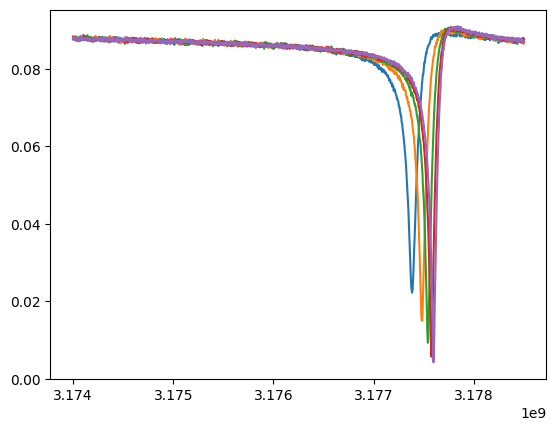

In [2]:
for i in range(5):
    plt.plot(f[i*3], y[i*3])
plt.show()

[np.float64(3177396015.351662), np.float64(3177425738.5037513), np.float64(3177465297.092204), np.float64(3177493053.069589), np.float64(3177517248.32517), np.float64(3177535860.681607), np.float64(3177553122.266517), np.float64(3177567739.1779227), np.float64(3177578963.2513194), np.float64(3177589919.7210145), np.float64(3177598675.12382), np.float64(3177605847.9824066), np.float64(3177611186.360817), np.float64(3177616313.2655973), np.float64(3177620591.6358814), np.float64(3177624106.122307), np.float64(3177626089.3329577), np.float64(3177627385.633292), np.float64(3177631000.0883617), np.float64(3177633128.948209), np.float64(3177634018.901468), np.float64(3177636237.409535), np.float64(3177637187.201648), np.float64(3177638255.5407705), np.float64(3177639203.872212), np.float64(3177640163.3113976), np.float64(3177639620.8188195), np.float64(3177641600.7662683), np.float64(3177640866.3325024), np.float64(3177640965.9103627), np.float64(3177641944.7714057), np.float64(3177642480.96

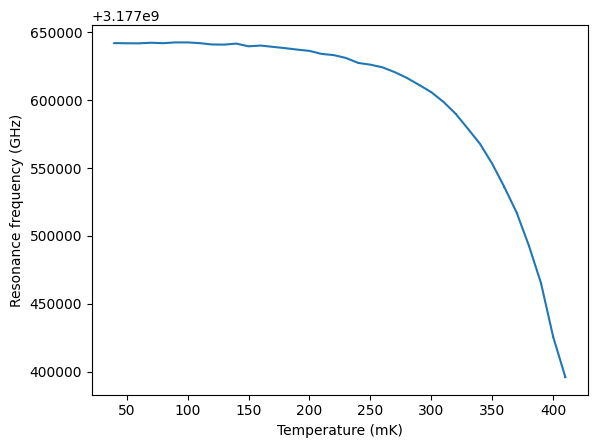

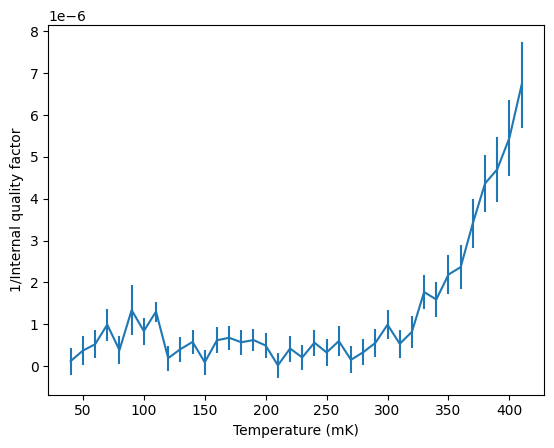

In [3]:
#empty result and err arrays
result_fr = []
err_fr = []
result_Qi = []
err_Qi = []

initial_guess = {
    "f0": 17000, #0.1,
    "phi": -0.2369, # 2.1,
    "Qc": 29208,
    "A": 0.0, #1.0,
    "B": 2.8643e-8 ,#1e-9,
    "C": 8.0398e-15,#1e-18,
    "D": -3.5988e-20, # 1e-27
    }

param_limits = {
    "Qc": (1e2, 1e7),
    "Qt": (1e2, 1e7),
    #'phi': (-20, 20),
    #'f0': (-1e6, 1e6),
    }

for i in range(0, len(T)):
    f_i = f[int(i)]
    y_i = y[int(i)]
    
    fmin = f_i[np.argmin(y_i)]
    initial_guess['fmin'] = fmin
    fwhm = peak_width(f_i, -y_i)
    
    mask = (f_i > fmin - 7 * fwhm) & (f_i < fmin + 7 * fwhm)
    f_i = f_i[mask]
    y_i = y_i[mask]

    # Estimate the initial guess of Qt
    Qt_guess = fmin / peak_width(f_i, -y_i)
    initial_guess['Qt'] = Qt_guess

    # Estimate the initial guess of K
    initial_guess['K'] = (np.max(y_i) - np.min(y_i)) * initial_guess['Qc'] / initial_guess['Qt']
    #print(f"Initial guess: {initial_guess}")

    fit_data = np.column_stack((f_i, y_i))
    fitter = Fitter(model_function=md.resonance_model, 
                    param_names=["f0", "phi", "Qt", "Qc", "A", "B", "C", "D", "K", "fmin"], 
                    data=fit_data, 
                    loss_function=LeastSquares,
                    params_initial_guess=initial_guess,
                    params_range=param_limits)

    fitter.model.set_fixed_params({"fmin": fmin})
    result = fitter.fit()
    result_dict = result.values.to_dict()
    err_dict = result.errors.to_dict()
    
    result_fr.append(result_dict['f0'] + fmin)
    err_fr.append(err_dict['f0'])
    
    result_Qi.append(abs((1/result_dict['Qt']-1/result_dict['Qc'])**-1))
    Qt = result_dict['Qt']
    Qc = result_dict['Qc']
    err_Qi.append(np.sqrt((err_dict['Qt'] * Qt**-2)**2 + (err_dict['Qc'] * Qc**-2)**2) * ((1/Qt-1/Qc)**-2))
    
    #print("Q_res" + str(i*2 + 40))
    #print("Q_i: " + str(abs((1/result_dict['Qt']-1/result_dict['Qc'])**-1)))
    
    #print(f"Result: {result_dict}")
    # grapher = fitPlotter(result, f_i, y_i, md.resonance_model)
    # grapher.simple_plot()
    
    
    
print(result_fr)
print(result_Qi)
print(T) 

plt.errorbar(T, result_fr, err_fr, linestyle='-', label='fr')
plt.ylabel('Resonance frequency (GHz)')
plt.xlabel('Temperature (mK)')
plt.show()

Qi_plot = 1/np.array(result_Qi)
err_Qi_plot = err_Qi*np.array(result_Qi)**-2

plt.errorbar(T, Qi_plot, err_Qi_plot, linestyle='-', label='Qi')
plt.ylabel('1/Internal quality factor')
plt.xlabel('Temperature (mK)')
plt.show()

Result: {'D0_k': 3.7134283064040425, 'w': np.float64(3177641828.5254445), 'Q0': np.float64(1861716.9554596313), 'a': 0.8}
Result D0 (meV): 0.3204338173630272 +- 0.0023889955620808646
T_C (K): 2.109902446820479 +- 0.0157303858355472


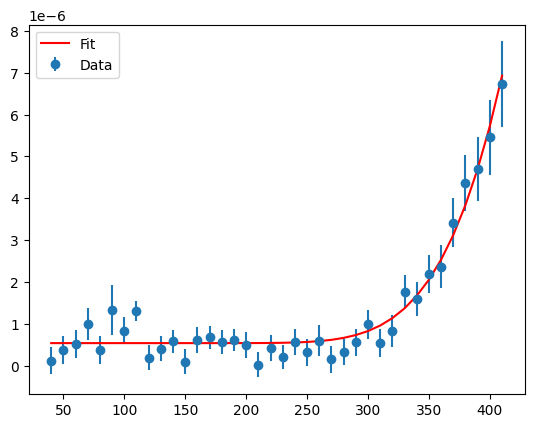

In [12]:
from scipy import constants as cs
mask = (np.array(T)<250.0)
mask2= (np.array(T)<150)
_Q0 = np.mean(np.array(Qi_plot)[mask])
w = np.mean(np.array(result_fr)[mask2])

initial_guess = {
    "Q0": _Q0**-1,
    "a": 0.8,
    "D0_k": 3.67,
    "w": w
    }

fit_data = np.column_stack((T, Qi_plot))
fitter = Fitter(model_function=md.qi_factor_model, 
                    param_names=["Q0", "a", "D0_k", "w"], 
                    data=fit_data, 
                    yerr=err_Qi_plot,
                    loss_function=LeastSquares,
                    params_initial_guess=initial_guess)

fitter.model.set_active_params(["D0_k"])
result = fitter.fit()

result_dict = result.values.to_dict()
result_dict['w'] = w
result_dict['Q0'] = _Q0**-1
result_dict['a'] = initial_guess['a']
err_dict = result.errors.to_dict()

print(f"Result: {result_dict}")
print(f"Result D0 (meV): {result_dict["D0_k"]*cs.k/(1.6e-22)} +- {err_dict['D0_k']*cs.k/(1.6e-22)}")
T_C = 2/3.52 * result_dict["D0_k"]
print(f"T_C (K): {T_C} +- {2/3.52 * err_dict['D0_k']}")
grapher = fitPlotter(result_dict, T, Qi_plot, md.qi_factor_model, err_y = err_Qi_plot)
grapher.simple_plot()